### CS 109A/STAT 121A/AC 209A/CSCI E-109A 

# Lab 8: Discriminant Analysis 


**Harvard University**<br>
**Fall 2017**<br>
**Instructors: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine**

---

# Table of Contents 

<ol start="0">
<li> Learning Goals </li>
<li> Temporal patterns in urban demographics </li>
<li> Geographic patterns in urban demographics </li>
</ol>

## Part 0: Learning Goals 

In this lab we'll work with demographics of a region of the cities of Pavlopolis and Kevinsville from the years 2000 to 2010.  We'll use the data to predict household economic status from its geographical location.

By the end of this lab, you will be able to:

- Implement different classifiers and calculate predictive accuracy of these classifiers,

- Compare different classifiers for general predictive accuracy and computational efficiency.


*This lab maps on to lectures 13 and 14 and homework 7. *

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy.stats import mode
from sklearn import linear_model
import matplotlib
import matplotlib.pyplot as plt
from sklearn import discriminant_analysis
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import train_test_split
%matplotlib inline


# Predicting Urban Demographic Changes



## Part 1: Temporal patterns in urban demographics
For this first part of lab, we aim to build a model for the city of Pavlopolis that accurately predicts household economic status from its geographical location.  We want the model to be robust, that is, the model should be accurate over many years (through 2010 and beyond). 

The data is contained in `dataset_1_year_2000.txt`, ..., `dataset_1_year_2010.txt`. The first two columns of each dataset are the adjusted latitude and longitude of some randomly sampled houses. The last column contains economic status of a household: 

0: low-income, 

1: middle-class, 

2: high-income 

Due to the migration of people in and out of the city, the distribution of each economic group over this region changes over the years. The city of Pavlopolis estimates that in this region there is approximately a 25% yearly increase in high-income households; and a 25% decrease in the remaining population, with the decrease being roughly the same amongst both the middle class and lower income households.


### Visualization
We start by importing and visualizing the data.  

In [2]:
#Load one file, check the data type, check that the data matches the description above
data2000_glance = np.loadtxt('datasets/dataset_1_year_2000.txt')
print(type(data2000_glance))
data2000_glance[:10, :]

<class 'numpy.ndarray'>


array([[0.54432757, 0.6245105 , 2.        ],
       [0.59468476, 0.72391292, 2.        ],
       [0.70018033, 0.78249208, 2.        ],
       [0.60126202, 0.97181171, 2.        ],
       [0.63199522, 0.74850249, 2.        ],
       [0.49427826, 0.60880108, 2.        ],
       [0.6096247 , 0.67672357, 2.        ],
       [0.76899244, 0.86092404, 2.        ],
       [0.59429045, 0.82042128, 2.        ],
       [0.45593116, 0.74428878, 2.        ]])

> **EXERCISE:** Fill in the code below to load the data and separate the predictors (variable `x`) and response (variable `y`).

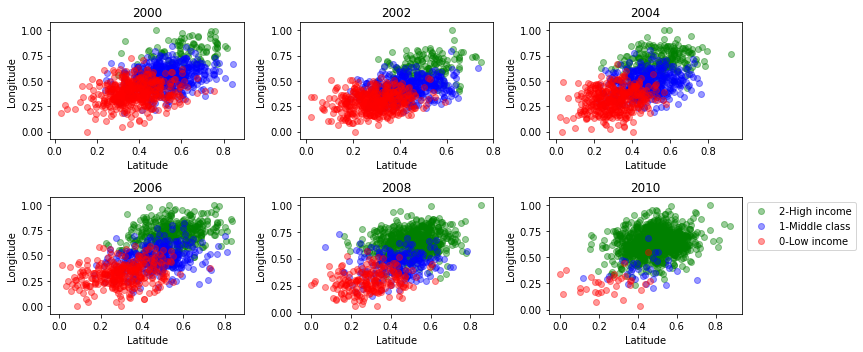

In [3]:
#Visualize data for every other year
fig, ax = plt.subplots(2, 3, figsize = (12, 5))

#Create index for subplots
ind = 0
#Iterate from year 0 to 10, with steps of 2
for i in range(0, 11, 2):
    
    #your code begins here
    #Load data
    data = np.loadtxt('datasets/dataset_1_year_' + str(2000 + i) + '.txt')
    
    #Split into predictor/response
    x = data[:, :-1]
    y = data[:, -1]
    
    #your code ends here

    #Plot each class for the current year in different colors         
    ax[ind // 3, ind % 3].scatter(x[y == 2, 0], x[y == 2, 1], color='green', alpha=0.4,
                                 label = '2-High income')
    ax[ind // 3, ind % 3].scatter(x[y == 1, 0], x[y == 1 ,1], 
                                 color='blue', alpha=0.4,
                                 label = '1-Middle class')
    ax[ind // 3, ind % 3].scatter(x[y == 0, 0], x[y == 0, 1], 
                                 color='red', alpha=0.4,
                                 label = '0-Low income')
    
    # LABEL AXIS, TITLE
    ax[ind // 3, ind % 3].set_xlabel('Latitude')
    ax[ind // 3, ind % 3].set_ylabel('Longitude')
    ax[ind // 3, ind % 3].set_title(str(2000 + i))
    
    #Update index
    ind = ind + 1

plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
plt.tight_layout()

> **EXERCISE:** What do you observe from the data visualizations?

> **YOUR DISCUSSION HERE:** 
- Generally the income level increases with latitude and longitude, irrespective of the year. 
- As time goes by, the proportion of high income people increases and the proportion of middle and lower income people decreases in approximately equal proportion as mentioned previously.

### Model comparison

Let's  compare the the following four classification schemes for addressing the problem of predicting household economic status from geographic location:

1. Training a  logistic regression model on one year and use it repeatedly
2. Training a Q/LDA model on one year and use it repeatedly
3. Training a KNN model on one year and use it repeatedly
4. Training a Q/LDA model yearly

We'll consider the following "goodness" factors:

1. general predictive accuracy
2. computational efficiency

> **EXERCISE:** Of the four models above, which ones do you believe are most computationally efficient?

> **YOUR DISCUSSION HERE:** 
- The most computationally efficient models are most likely the LDA model followed by the QDA model trained on one year and used repeatedly (2).

We'll now train three single models  (logistic regression, LDA, and KNN) once, and explore the accuracy of these models over time.


> **EXERCISE:** Fill in the code below to fit a logistic regression (variable `logreg`), KNN (variable `knn`), and lda (variable `lda`) models on the 2000 data.

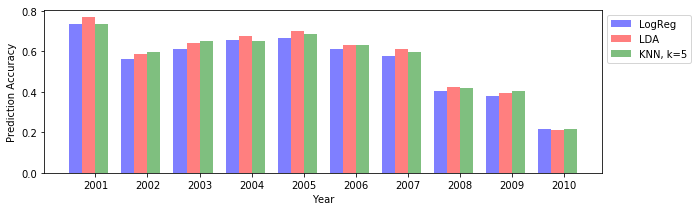

In [4]:
#Load data for year 2000
data = np.loadtxt('datasets/dataset_1_year_2000.txt')

#Split predictors, response
x = data[:, :-1]
y = data[:, -1]

#your code begins here
#Fit a logistic regression model on year 2000 data
logreg = linear_model.LogisticRegression(C=1e9) # unregularized
logreg.fit(x, y)

#Fit a lda model on year 2000 data
lda = discriminant_analysis.LinearDiscriminantAnalysis()
lda.fit(x, y)

#Fit a knn model on year 2000 data
knn = KNN(n_neighbors=5)
knn.fit(x, y)
#your code ends here

acc_log = []
acc_lda = []
acc_knn = []

#Iterate through all the years
for i in range(1, 11):
    #Load data for year 2000 + i 
    data_i = np.loadtxt('datasets/dataset_1_year_' + str(2000 + i) + '.txt')
    
    #Split predictors, response
    x_i = data_i[:, :-1]
    y_i = data_i[:, -1]

    #Compute predictive accuracies of various models trained on 2000 data
    acc_log.append(logreg.score(x_i, y_i))
    acc_lda.append(lda.score(x_i, y_i))
    acc_knn.append(knn.score(x_i, y_i))
            
#Plot accuracy over years
years = np.arange(1,11) + 2000 # x-axis is years 2001-2010
width = 0.25 # width of bar

plt.figure(figsize = (10,3))
plt.bar(years, acc_log, width, color='blue', alpha=0.5, label='LogReg')
plt.bar(years + width, acc_lda, width, color='red', alpha=0.5, label='LDA')
plt.bar(years + 2 * width, acc_knn, width, color='green', alpha=0.5, label='KNN, k=5')

#Labels
plt.xlabel('Year')
plt.ylabel('Prediction Accuracy')
plt.legend(loc = 'upper left', bbox_to_anchor=(1,1)) # legend upper left outside
plt.xticks(years + width + 0.125, years); # set x-ticks spacing

> **EXERCISE:** Are these three models robust?  That is, do these models perform well over the years?

> **YOUR DISCUSSION HERE:** 
These models are not robust as they do not perform well over the years. This is because the year 2000 data is not representative of the behavior in subsequent years as evidenced by the latitude-longitude plots we made previously. 

We'll now consider the remaining modeling option:

1. Training a Q/LDA model yearly



What does it mean to train a QDA or LDA model for each year? Recall that Q/LDA classifiers first model the distribution of the data within each class using a normal distribution, $\mathcal{N}(\mu, \Sigma)$. Then the Q/LDA models the distribution of the data amongst the classes. For us, since we have three classes, this means that our "model" consists of the following 6 pieces of information (three for each class, two to define the distribution of data in the class and one to define the class proportion):

1. Class 0: 
   - Distribution: $p(x | y = 0) = \mathcal{N}(\mu_0, \Sigma_0)$
   - Proportion: $p(y=0)=\pi_0 = \frac{\text{data in Class 0}}{\text{total number of data}}$

2. Class 1: 
   - Distribution: $p(x | y = 1) = \mathcal{N}(\mu_1, \Sigma_1)$
   - Proportion: $p(y=1)=\pi_1 = \frac{\text{data in Class 1}}{\text{total number of data}}$
   
3. Class 2: 
   - Distribution: $p(x | y = 2) = \mathcal{N}(\mu_2, \Sigma_2)$
   - Proportion: $p(y=2)=\pi_2 = \frac{\text{data in Class 2}}{\text{total number of data}}$
   
Retraining a Q/LDA model means re-estimating $\mu, \Sigma$ and $\pi$ for each class. 

> **EXERCISE:** At the beginning of lab we were given information on the projected yearly growth rate of the classes, so we don't need the entire set of population data to re-estimate $\pi$ for each class.  Use this information to write down estimates for $\pi_2^{\text{year i + 1}}$.  Then, assuming that the total population is approximately constant over the years, estimate $\pi_0^{\text{year i + 1}}$ and $\pi_1^{\text{year i + 1}}$.

> **YOUR DISCUSSION HERE:** 
Since we are told there is a 25% yearly increase in the high income group, our estimate for:
$$\pi_2^{\text{year i + 1}} = 1.25\pi_2^{\text{year i}}$$
Then, assuming that the total population is approximately constant over the years and the classes decrease by the same amount, our estimates for:
$$\pi_0^{\text{year i + 1}}  = \pi_1^{\text{year i + 1}} = \frac{1 - 1.25 * \pi_2^{\text{year i}}}{2}$$

On the other hand, if the distribution of the data within each class changes (i.e. $\mu$ and $\Sigma$ changes within each class) then we will need re-estimate them using new data each year. Let's check, using data visualization, to see if this is indeed the case.

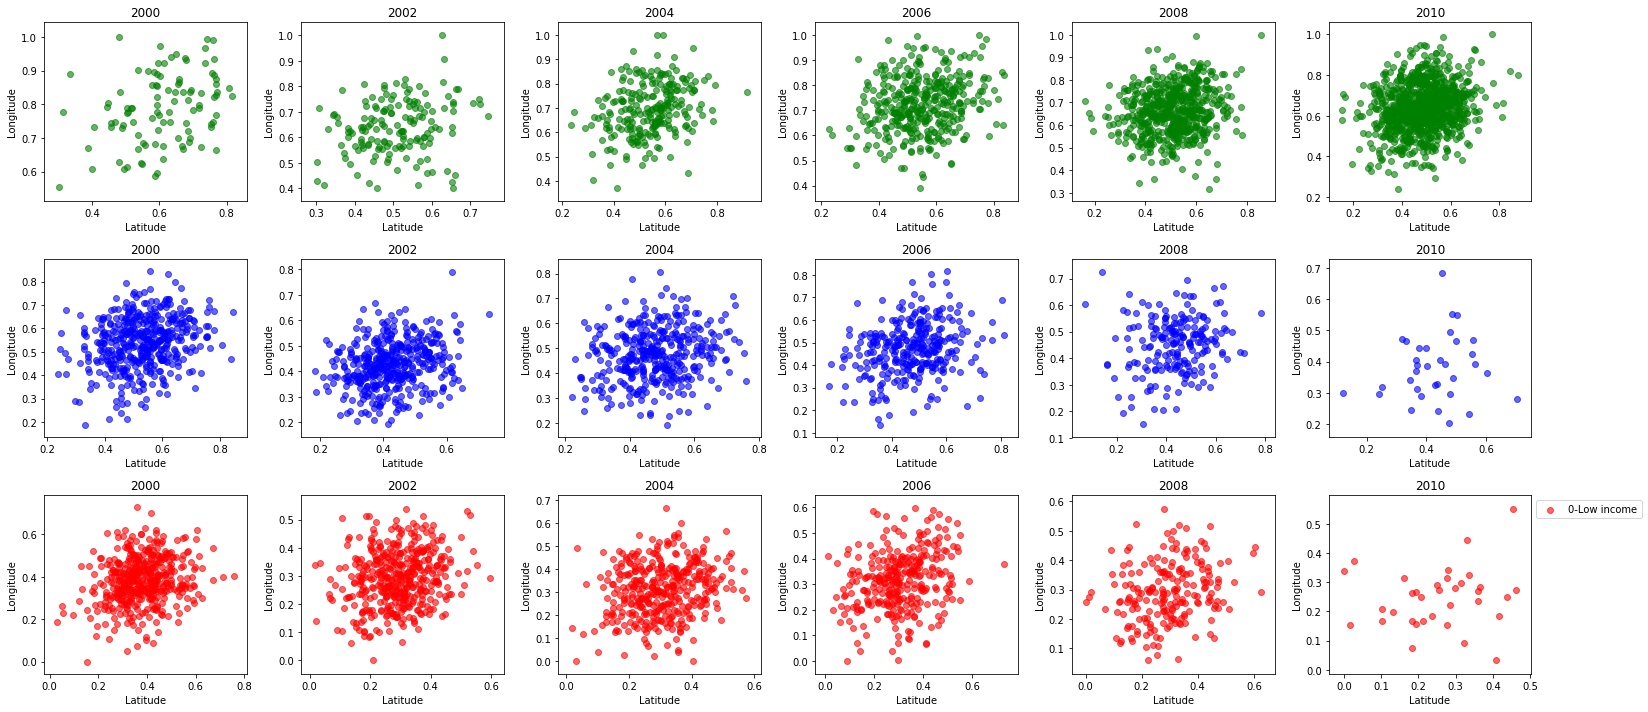

In [5]:
#Visualize data for every other year
fig, ax = plt.subplots(3, 6, figsize = (23, 10))

#Iterate from year 0 to 10, with steps of 2
for i in range(0, 11, 2):
    #Load data
    data = np.loadtxt('datasets/dataset_1_year_' + str(2000 + i) + '.txt')
    
    #Split into predictor/response
    x = data[:, :-1]
    y = data[:, -1]
    
    
    #Plot each class for the current year in different colors
    ax[0, i // 2].scatter(x[y == 2, 0], x[y == 2, 1],
                         color='g', alpha=0.6,
                         label = '2-High income')
    ax[1, i // 2].scatter(x[y == 1, 0], x[y == 1 ,1], 
                         color='b', alpha=0.6,
                         label = '1-Middle class')
    ax[2, i // 2].scatter(x[y == 0, 0], x[y == 0, 1], 
                         color='r', alpha=0.6,
                         label = '0-Low income')
    
    #Labels
    ax[0, i // 2].set_xlabel('Latitude')
    ax[0, i // 2].set_ylabel('Longitude')
    ax[0, i // 2].set_title(str(2000 + i))
    
    #Labels
    ax[1, i // 2].set_xlabel('Latitude')
    ax[1, i // 2].set_ylabel('Longitude')
    ax[1, i // 2].set_title(str(2000 + i))
    
    # LABEL AXIS, TITLE
    ax[2, i // 2].set_xlabel('Latitude')
    ax[2, i // 2].set_ylabel('Longitude')
    ax[2, i // 2].set_title(str(2000 + i))


plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
plt.tight_layout()

> **EXERCISE:** Comment on how the distribution in each class appears to change over the years.  Does this effect the efficiency of Q/LDA models?

> **YOUR DISCUSSION HERE:** 
Looking at the data in each class over the years, even though the number of points varies, we see that the distribution within each class is not changing. We can see that the data in each class is approximately multivariate normal distributed with the parameters of the distribution ($\mu$ and $\Sigma$) for each class more or less constant over time. So we can have a very efficient Q/LDA model since we only need to re-estimate the class proportions based on our equations above.



So how efficient is our Q/LDA model? We train the model once on a single year's worth of data. Then, for any subsequent year, the update is just a few lines of arithmetic. For example, say we train our Q/LDA model on 2000 data, given a point from 2001, $x^{2001}$, we predict the class label for $x^{2001}$ by:

1. find the probability that $x^{2001}$ will be labeled Class 0 to 2 using our model from 2000:
$$
\begin{aligned}
p_{2000}(y=0 | x^{2001}) &= p_{2000}(x^{2001} | y=0) p_{2000}(y=0) = \mathcal{N}(x^{2001}; \mu_0, \Sigma_0) \pi_0^{2000}\\
p_{2000}(y=1 | x^{2001}) &= p_{2000}(x^{2001} | y=1) p_{2000}(y=1) = \mathcal{N}(x^{2001}; \mu_1, \Sigma_1) \pi_1^{2000}\\
p_{2000}(y=2 | x^{2001}) &= p_{2000}(x^{2001} | y=2) p_{2000}(y=2) = \mathcal{N}(x^{2001}; \mu_2, \Sigma_2) \pi_2^{2000}
\end{aligned}
$$
2. adjust the probabilities predicted using the 2000 model, by updating $\pi_i$ with 2001 class proportions:
$$
\begin{aligned}
p_{2001}(y=0 | x^{2001}) &= p_{2000}(y=0 | x^{2001}) \frac{\pi_0^{2001}}{\pi_0^{2000}}\\
p_{2001}(y=1 | x^{2001}) &= p_{2000}(y=1 | x^{2001}) \frac{\pi_1^{2001}}{\pi_1^{2000}}\\
p_{2001}(y=2 | x^{2001}) &= p_{2000}(y=2 | x^{2001}) \frac{\pi_2^{2001}}{\pi_2^{2000}}\\
\end{aligned}
$$
3. take the maximum of $\{p_{2001}(y=0 | x^{2001}), p_{2001}(y=1 | x^{2001}), p_{2001}(y=2 | x^{2001}) \}$ and predict the class label corresponding to the maximum probability.

In terms of efficiency, clearly updating a Q/LDA model is cheaper than retraining a KNN or logistic regression each year. Let's see if the accuracy is comparable.

> **EXERCISE: ** Fill in the code below to re-estimate the class proportions (see equations from two exercises ago).

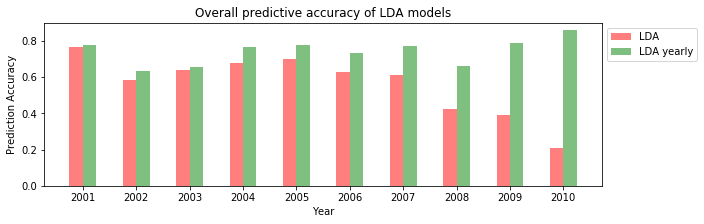

In [6]:
#Load data for year 2000
data = np.loadtxt('datasets/dataset_1_year_2000.txt')

#Split predictors, response
x = data[:, :-1]
y = data[:, -1]

#your code begins here
#Fit a lda model on year 2000 data
lda = discriminant_analysis.LinearDiscriminantAnalysis()
lda.fit(x, y)
#your code ends here

acc_lda_corrected = [] # Store corrected LDA accuracies

#Store class proportions in 2000
p0_2000 = (y==0).mean()
p1_2000 = (y==1).mean()
p2_2000 = (y==2).mean()

#Store class proportions in current year
p0_current = (y==0).mean()
p1_current = (y==1).mean()
p2_current = (y==2).mean()

for k in range(1, 11):
    #Load data
    data_i = np.loadtxt('datasets/dataset_1_year_' + str(2000 + k) + '.txt')
    
    #Split into predictor, response
    x_i = data_i[:, :-1]
    y_i = data_i[:, -1]
    
    x_train, x_test, y_train, y_test = train_test_split(x_i, y_i, test_size=0.30, random_state=0)
    
    #your code begins here
    #Re-estimate class proportions (25% increase in p2, adjust p0, p1 accordingly)
    p2_current = 1.25 * p2_current
    p1_current = (1. - p2_current) / 2.
    p0_current = (1. - p2_current) / 2.

    #your code ends here
    
    #Re-estimate class label probabilities 
    pred_logprob = lda.predict_log_proba(x_test) # compute log-probabilities
    pred_logprob[:, 0] = pred_logprob[:, 0] + np.log(p0_current / p0_2000) # correction for class 0
    pred_logprob[:, 1] = pred_logprob[:, 1] + np.log(p1_current / p1_2000) # correction for class 1
    pred_logprob[:, 2] = pred_logprob[:, 2] + np.log(p2_current / p2_2000) # correction for class 2

    
    #Predict class label using re-estimated probabilities
    y_pred = pred_logprob.argmax(axis = 1)
    
    #Compute accuracy 
    acc_lda_corrected.append(np.mean(y_test == y_pred))
    
#Plot accuracy over years
years = np.arange(1, 11) + 2000 # x-axis is years 2001-2010
width = 0.25 # width of bar

plt.figure(figsize=(10,3))
plt.bar(years + width, acc_lda, width, color='red', alpha=0.5, label='LDA')
plt.bar(years + 2 * width, acc_lda_corrected, width, color='green', alpha=0.5, label='LDA yearly')



#Labels
plt.xlabel('Year')
plt.ylabel('Prediction Accuracy')
plt.legend(loc = 'upper left', bbox_to_anchor=(1, 1)) # legend upper left outside
plt.title('Overall predictive accuracy of LDA models')
plt.xticks(years + width + 0.125, years); # set x-ticks spacing

Compared to training a model once and using it repeatedly, training the Q/LDA yearly performs better in terms of predictive accuracy.  It isn't significantly more expensive though.

** Note:** Why LDA and not QDA? Well since we've already observed that the distributions of data within the three classes are very simliar (in terms of shape) we can assume that the covariance matrices for all three classes will be the same - hence our model is LDA rather than QDA

** Conclusions: **  Based on the data visualization from the first 5 years, it's clear that while the class proportions are changing, the class distributions are not (the center and shape of the three classes are constant through time). Thus, updating our LDA on a yearly basis is simple, as this just requires us to adjust our estimates of the class proportions $\pi$.

## Part 2: Geographic patterns in urban demographics
In `dataset_2.txt` and `dataset_3.txt` you have the demographic information for a random sample of houses in two regions in Kevinsville. There are only two economic brackets for the households in these datasets: 

0: low-income or middle-class, 

1: high-income. 

The data for each region is shown in the visualizations below.


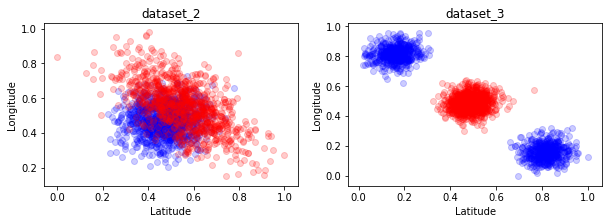

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

data = np.loadtxt('datasets/dataset_2.txt')
x = data[:,0:-1]
y = data[:,-1]

# Plot data
ax[0].scatter(x[y == 1, 0], x[y == 1, 1], color='b', alpha=0.2)
ax[0].scatter(x[y == 0, 0], x[y == 0, 1], color='r', alpha=0.2)

# Label axes, set title
ax[0].set_title('dataset_2')
ax[0].set_xlabel('Latitude')
ax[0].set_ylabel('Longitude')

data = np.loadtxt('datasets/dataset_3.txt')
x = data[:,0:-1]
y = data[:,-1]

# Plot data
ax[1].scatter(x[y == 1, 0], x[y == 1, 1], color='b', alpha=0.2)
ax[1].scatter(x[y == 0, 0], x[y == 0, 1], color='r', alpha=0.2)

# Label axes, set title
ax[1].set_title('dataset_3')
ax[1].set_xlabel('Latitude')
ax[1].set_ylabel('Longitude')

plt.show()

>** EXERCISE:** For each region, comment on the appropriateness of using KNN for classification.

> **YOUR DISCUSSION HERE:**
The classes in dataset in dataset_3 are well separated so we would expect KNN to have a high classification accuracy. However, there is a lot of overlap between the classes in dataset_2 so we could expect a poorer classification accuracy.

Below is code for visualizing decision boundaries.

In [8]:
#--------  plot_decision_boundary
# A function that visualizes the data and the decision boundaries
# Input: 
#      x (predictors)
#      y (labels)
#      poly_flag (a boolean parameter, fits quadratic model if true, otherwise linear)
#      title (title for plot)
#      ax (a set of axes to plot on)
# Returns: 
#      ax (axes with data and decision boundaries)

def plot_decision_boundary(x, y, model, poly_flag, title, ax):
    # Plot data
    ax.scatter(x[y == 1, 0], x[y == 1, 1], c='blue', label='Normal', cmap=plt.cm.coolwarm)
    ax.scatter(x[y == 0, 0], x[y == 0, 1], c='red', label='Normal', cmap=plt.cm.coolwarm)
    
    # Create mesh
    interval = np.arange(0,1,0.01)
    n = np.size(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1, 1)
    x2 = x2.reshape(-1, 1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh points
    if(poly_flag):
        quad_features = preprocessing.PolynomialFeatures(degree=2)
        xx = quad_features.fit_transform(xx)
    yy = model.predict(xx)    
    yy = yy.reshape((n, n))

    # Plot decision surface
    x1 = x1.reshape(n, n)
    x2 = x2.reshape(n, n)
    ax.contourf(x1, x2, yy, cmap=plt.cm.coolwarm, alpha=0.1)

    
    # Label axes, set title
    ax.set_title(title)
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    
    return ax



In [9]:
#--------  fit_and_plot_models
# A function that visualizes the data and the decision boundaries
# Input: 
#      file_name (name of the file containing dataset)
# Returns: 
#      None

def fit_and_plot_models(file_name): 
    data = np.loadtxt(file_name)
    x = data[:,0:-1]
    y = data[:,-1]

    fig, ax = plt.subplots(1, 4, figsize=(15, 3))

    # Plain Logistic Regression
    logreg = linear_model.LogisticRegression()
    logreg.fit(x, y)
    acc_logreg = logreg.score(x, y)

    str_title = 'LogReg (acc = ' + str(acc_logreg) + ')'
    ax[0] = plot_decision_boundary(x, y, logreg, False, str_title, ax[0])

    # LDA
    lda = discriminant_analysis.LinearDiscriminantAnalysis()
    lda.fit(x, y)
    acc_lda = lda.score(x, y)

    str_title = 'LDA (acc = ' + str(acc_lda) + ')'
    ax[1] = plot_decision_boundary(x, y, lda, False, str_title, ax[1])

    # QDA
    qda = discriminant_analysis.QuadraticDiscriminantAnalysis()
    qda.fit(x, y)
    acc_qda = qda.score(x, y)

    str_title = 'QDA (acc = ' + str(acc_qda) + ')'
    ax[2] = plot_decision_boundary(x, y, qda, False, str_title, ax[2])

    # Logistic Regression with Quadratic Terms
    quad_features = preprocessing.PolynomialFeatures(degree = 2)
    x_expanded = quad_features.fit_transform(x)
    logreg_poly = linear_model.LogisticRegression(C=1000)
    logreg_poly.fit(x_expanded, y)
    acc_logreg_poly = logreg_poly.score(x_expanded, y)
    
    str_title = 'LogReg-poly (acc = ' + str(acc_logreg_poly) + ')'
    ax[3] = plot_decision_boundary(x, y, logreg_poly, True, str_title, ax[3])
    
    plt.tight_layout()
    plt.show()

>** EXERCISE:** Choose between Q/LDA and logistic regression by visualizing various types decision boundaries.  Explore and discuss.

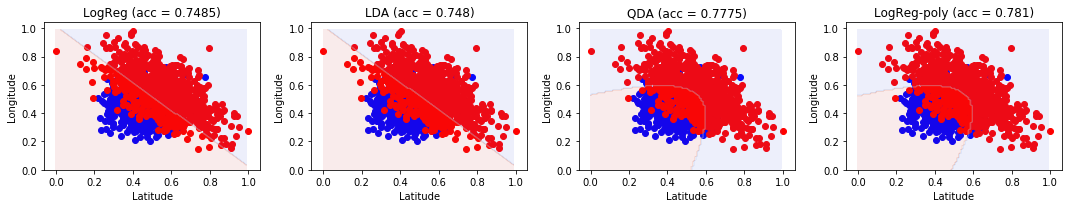

In [10]:
fit_and_plot_models('datasets/dataset_2.txt')

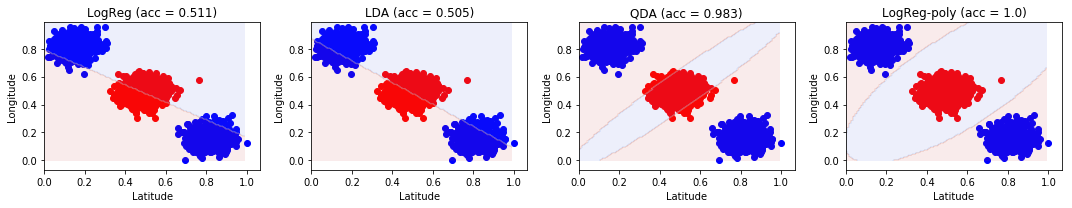

In [11]:
fit_and_plot_models('datasets/dataset_3.txt')

> **YOUR DISCUSSION HERE:** 
The classes in both datasets  clearly cannot be separated by linear decision boundaries, so we can rule out the linear models without polynomial terms (LogReg and LDA). The quadratic decision boundaries (QDA and LogReg-Poly) are far better at separating the class labels. Both these models have very high classification accuracy in dataset_3.txt which in which the data is more separable (perfect accuracy for the LogReg-Poly model suggests it may be overfitting). The classification accuracy is poorer in dataset_2.txt since there is more overlap between the classes. Clearly with dataset_3.txt, the distribution of the blue class cannot be multivariate normal, which does not satify the assumptions of QDA. Hence, we should choose the LogReg-poly model but should apply regularization to control the overfitting. 